In [1]:
import pmdarima
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils import plot_PIs, compute_coverage_len
import data_loaders
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import arch

2022-09-21 14:03:39.289529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Data loading and preprocessing

In this example, we consider meterological data. We specify the forecast ``horizon`` variable and the main ``seasonality`` in the time series (in this case ``seasonality=24`` since the data have hourly resolution).

In [2]:
# load data
df = data_loaders.get_met_data()
seasonality=24  # the main seasonality of the data
horizon=24      # we want to predict 1-day ahead

df = df[:2000]

We use 80% of the time series for training and the remaining 20% for testing. 

In [3]:
# train/test split
n_train = int(df.shape[0]*0.8)
train_df = df[:n_train]
test_df = df[n_train:]

Next we separate the target variable ``T (degC)`` from the other variables, which are used as exogenous variables.

In [4]:
# separate exogenous variables (x) from the target variable (y)
y_train = train_df['T (degC)'].values
x_train = train_df.drop('T (degC)', axis=1).values
y_test = test_df['T (degC)'].values
x_test = test_df.drop('T (degC)', axis=1).values

print(f"y_train: {y_train.shape}, x_train: {x_train.shape}, y_test: {y_test.shape}, x_test: {x_test.shape}")

y_train: (1600,), x_train: (1600, 18), y_test: (400,), x_test: (400, 18)


Finally, we normalize the data in the range $[-1,1]$. We use a different scaler for the exogenous variables ($x$) and the target variable ($y$).

In [5]:
# instantiate the scaler
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

# Normalize data
y_train = y_scaler.fit_transform(y_train[...,None])
x_train = x_scaler.fit_transform(x_train)
y_test = y_scaler.transform(y_test[...,None])
x_test = x_scaler.transform(x_test)

## ARIMA model

### Fit the ARIMA model
We use ``auto_arima`` to find the best ARIMA model for the data at hand. The procedure takes a while. 

In [6]:
# automatically fit the optimal ARIMA model for given time series
arima_model = pmdarima.auto_arima(
    y_train, exogenous=x_train,
    start_p=1, start_q=1,
    max_p=3, max_q=3, m=seasonality,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',   # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=-23290.564, Time=50.48 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=-22249.200, Time=23.27 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=-22913.990, Time=34.97 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=-23292.536, Time=47.57 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=-22469.955, Time=32.07 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=-23207.089, Time=27.69 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=95.04 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=-22934.091, Time=51.14 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=77.79 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=-23080.577, Time=52.53 sec
 ARIMA(0,1,2)(0,1,1)[24]             : AIC=-23287.506, Time=26.93 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=-23275.028, Time=20.22 sec
 ARIMA(1,1,2)(0,1,1)[24]             : AIC=-23285.934, Time=22.67 sec
 ARIMA(0,1,1)(0,1,1)[24] intercept   : AIC=-23225.901, Time=7

After the model is fit, we collect the training residuals $\epsilon_t = \hat{y}_t - y_t$. The residuals give us an idea of how well the ARIMA model fits the training data. Also, the residuals will be used later to fit a GARCH model.

In [7]:
# collect training residuals
train_res = arima_model.arima_res_.resid

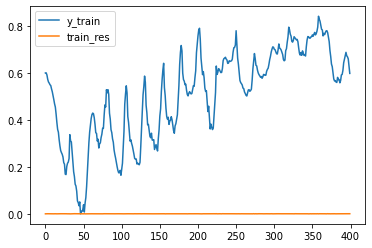

In [11]:
plt.plot(y_train[100:500], label='y_train')
plt.plot(train_res[100:500], label='train_res')
plt.legend()
plt.show()

Ideally, the residuals should be pure noise and, thus, uncorrelated with each other. To check this, we look at the autocorrelation plot.

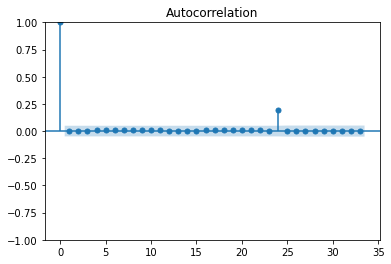

In [9]:
squared_train_res = train_res**2 
plot_acf(squared_train_res)
plt.show()

### Make predictions

Now that the model is fit, we can use it to make predictions at ``horizon`` steps ahead. After making each prediction, we update the ARIMA model with the new data as they become available. Also, we collect the residuals on the test data and the CI at the $\alpha=0.1$ confidence level. 

In [13]:
# Make predictions and update the model
forecast, test_res, CI = [], [], []
for step in tqdm(range(y_test.shape[0]//horizon)):
    y_hat, conf_int = arima_model.predict(n_periods=horizon, return_conf_int=True, alpha=0.1, exogenous=x_test[step*horizon:(step+1)*horizon])
    forecast.append(y_hat)
    CI.append(conf_int)
    test_res.append(y_test[step*horizon:(step+1)*horizon, 0] - y_hat)
    arima_model.update(y_test[step*horizon:(step+1)*horizon], exogenous=x_test[step*horizon:(step+1)*horizon])
    
# collect predictions, CI, and residuals
preds = np.hstack(forecast)[...,None]
preds_ci = np.vstack(CI)
test_res = np.hstack(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [07:32<00:00, 28.26s/it]


In [14]:
# post-process output
y_hat = y_scaler.inverse_transform(preds)
y_hat_ci = y_scaler.inverse_transform(preds_ci)
y_test = y_scaler.inverse_transform(y_test[:preds.shape[0]])

<Figure size 432x288 with 0 Axes>

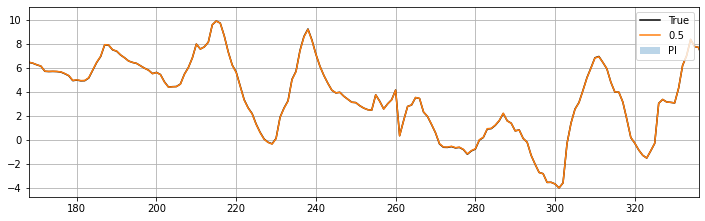

PI coverage: 0.0%, PI avg. length: 0.000, CWC: 0.000


In [15]:
# plot and print arima results
plot_PIs(y_test[:preds.shape[0]], y_hat, y_hat_ci[:,0], y_hat_ci[:,1], x_lims=[168,336])
compute_coverage_len(y_test[:preds.shape[0],0], preds_ci[:,0], preds_ci[:,1], verbose=True)

## GARCH models

ARIMA models do not model a change in the variance over time. On the other hand, an ARCH method models the variance at a time step as a function of the residual errors from a mean process. ARCH expects the series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component.
In practice, ARCH can be used to model the expected variance on the residuals obtained from an ARIMA model.

Generalized Autoregressive Conditional Heteroskedasticity (GARCH), is an extension of the ARCH model that incorporates a MA component together with the AR component.
The introduction of a MA component allows GARCH to both model the conditional change in variance over time as well as changes in the time-dependent variance.

Similarly to ARIMA, GARCH is parametrized by
- p: the number of lag variances.
- q: the number of lag residual errors.
This parameters can be set by looking at the ACF and PACF of the squared residuals.

In this case, we set $p=1$ and $q=2$.

In [ ]:
tot_res = np.concatenate((train_res, test_res))

# specify garch model
garch = arch.arch_model(
    tot_res, 
    vol='garch', 
    p=1, q=2)

# fit the garch model
garch_fitted = garch.fit(
    last_obs=train_res.shape[0] # specify where train data ends
    )

In [ ]:
# forecasts with garch
garch_forecast = garch_fitted.forecast(
    start=train_res.shape[0], # specify where forecasting starts
    horizon=horizon, 
    )

garch_var = garch_forecast.variance['h.'+str(horizon)].iloc[train_res.shape[0]:].values
garch_mean = garch_forecast.mean['h.'+str(horizon)].iloc[-test_res.shape[0]:].values

In [ ]:
plt.plot(test_res, label='test_res', color='k')
plt.plot(garch_mean-np.sqrt(garch_var), color='b', label='garch_std')
plt.plot(garch_mean+np.sqrt(garch_var), color='b')
plt.plot(garch_mean, label='garch_mean')
plt.legend()
plt.show()

In [ ]:
# post-process output
garch_std = np.sqrt(garch_var)[...,None]
garch_ci_low = y_scaler.inverse_transform(preds-garch_std)
garch_ci_hi = y_scaler.inverse_transform(preds+garch_std) 

In [ ]:
# plot garch results
plot_PIs(y_test, y_hat, garch_ci_low, garch_ci_hi, x_lims=[168,336], label_pi='Variance')
compute_coverage_len(y_test[:preds.shape[0]].flatten(), garch_ci_low[:,0], garch_ci_hi[:,0], verbose=True)